
Confusion Matrix:
 [[1020   77]
 [   9  446]]

Accuracy: 0.9445876288659794
Precision: 0.8527724665391969
Recall: 0.9802197802197802
F1 Score: 0.9120654396728016


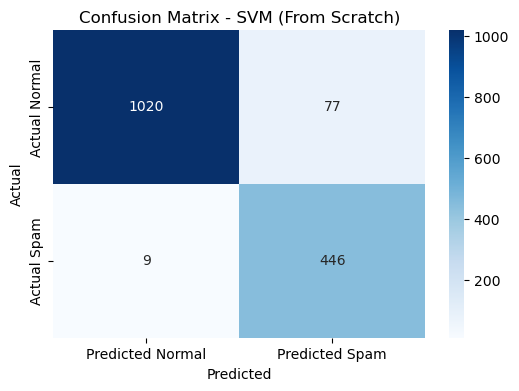


----- RAW TEXT TEST RESULTS -----

Congratulations! You have won a lottery. Claim your prize now!  --->  SPAM
Please review the attached report and let me know your feedback.  --->  HAM (Normal)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1) LOAD DATA
# -------------------------------------------------------
df = pd.read_csv("emails.csv")

data = df.drop(columns=['Email No.'])
X = data.drop(columns=['Prediction']).values
y = data['Prediction'].values

# Convert labels 0 -> -1 and 1 -> +1 because SVM requires {-1, +1}
y = np.where(y == 0, -1, 1)

# -------------------------------------------------------
# 2) TRAIN / TEST SPLIT
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# -------------------------------------------------------
# 3) SVM FROM SCRATCH
# -------------------------------------------------------
class SVM_From_Scratch:
    def __init__(self, learning_rate=0.0001, lambda_param=0.01, n_iters=500):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iters):
            for idx, x in enumerate(X):
                condition = y[idx] * (np.dot(x, self.w) + self.b) >= 1
                
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - x * y[idx])
                    self.b -= self.lr * (-y[idx])
    
    def predict(self, X):
        return np.where((np.dot(X, self.w) + self.b) >= 0, 1, -1)

# -------------------------------------------------------
# 4) TRAIN MODEL
# -------------------------------------------------------
svm = SVM_From_Scratch()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Convert labels back to 0 and 1
y_test_normal = np.where(y_test == -1, 0, 1)
y_pred_normal = np.where(y_pred == -1, 0, 1)

# -------------------------------------------------------
# 5) METRICS
# -------------------------------------------------------
cm = confusion_matrix(y_test_normal, y_pred_normal)
acc = accuracy_score(y_test_normal, y_pred_normal)
prec = precision_score(y_test_normal, y_pred_normal)
rec = recall_score(y_test_normal, y_pred_normal)
f1 = f1_score(y_test_normal, y_pred_normal)

print("\nConfusion Matrix:\n", cm)
print("\nAccuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

# -------------------------------------------------------
# 6) CONFUSION MATRIX PLOT
# -------------------------------------------------------
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Predicted Normal", "Predicted Spam"],
            yticklabels=["Actual Normal", "Actual Spam"])
plt.title("Confusion Matrix - SVM (From Scratch)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# -------------------------------------------------------
# 8) CLASSIFY RAW TEXT INPUTS (TEST CASES)
# -------------------------------------------------------
import re

# Get vocabulary from dataset (BoW column names)
bow_words = data.drop(columns=['Prediction']).columns.tolist()
word_to_index = {word: idx for idx, word in enumerate(bow_words)}

def classify_email(text):
    # Lowercase & remove non-letters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()

    # Create zero vector for new email
    vec = np.zeros(len(bow_words))

    # Convert to Bag-of-Words vector
    for word in words:
        if word in word_to_index:
            vec[word_to_index[word]] += 1

    # Predict using SVM
    prediction = svm.predict(vec.reshape(1, -1))[0]
    return "SPAM" if prediction == 1 else "HAM (Normal)"


# -------------------- SAMPLE TESTS --------------------
test1 = "Congratulations! You have won a lottery. Claim your prize now!"
test2 = "Please review the attached report and let me know your feedback."

print("\n----- RAW TEXT TEST RESULTS -----\n")
print(test1, " ---> ", classify_email(test1))
print(test2, " ---> ", classify_email(test2))



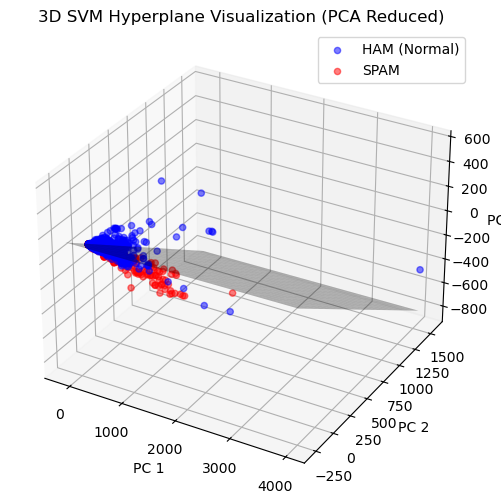

In [8]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Reduce features to 3D using PCA
pca = PCA(n_components=3)
X_train_3D = pca.fit_transform(X_train)

# Project weight vector into PCA space
w_pca = pca.components_[:3].dot(svm.w)
b_pca = svm.b

# Create a 3D scatter plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot HAM (-1) and SPAM (1)
ax.scatter(X_train_3D[y_train == -1][:, 0], X_train_3D[y_train == -1][:, 1], X_train_3D[y_train == -1][:, 2],
           c='blue', label='HAM (Normal)', alpha=0.5)

ax.scatter(X_train_3D[y_train == 1][:, 0], X_train_3D[y_train == 1][:, 1], X_train_3D[y_train == 1][:, 2],
           c='red', label='SPAM', alpha=0.5)

# Create grid to draw separating plane
xx, yy = np.meshgrid(
    np.linspace(min(X_train_3D[:,0]), max(X_train_3D[:,0]), 20),
    np.linspace(min(X_train_3D[:,1]), max(X_train_3D[:,1]), 20)
)

# Solve plane equation: w0*x + w1*y + w2*z + b = 0 → z = -(w0*x + w1*y + b) / w2
zz = -(w_pca[0] * xx + w_pca[1] * yy + b_pca) / w_pca[2]

# Plot the plane
ax.plot_surface(xx, yy, zz, alpha=0.3, color='black')

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("3D SVM Hyperplane Visualization (PCA Reduced)")
ax.legend()
plt.show()

